# 1. Data Cleaning (Làm sạch dữ liệu)

**Nhập thư viện**

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Kiểm tra ảnh Test**

In [42]:
img = cv2.imread("./Model/test_image/IMG_20221228_224730~2.jpg")
img.shape

(343, 339, 3)

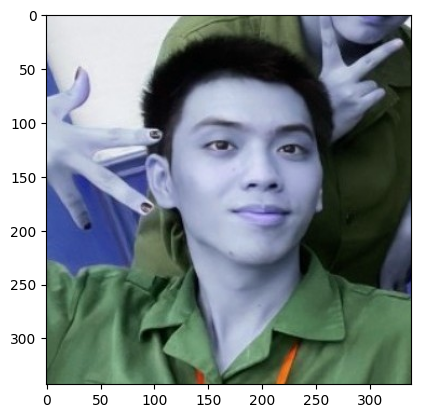

In [43]:
plt.imshow(img)

In [45]:
# Translate Image to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
gray

(343, 339)


array([[225, 225, 226, ...,  69,  88, 165],
       [224, 224, 225, ...,  76, 127, 206],
       [222, 223, 224, ..., 119, 181, 233],
       ...,
       [ 78,  81,  84, ...,  88,  86,  85],
       [ 78,  82,  86, ...,  89,  88,  87],
       [ 80,  82,  85, ...,  83,  82,  81]], dtype=uint8)

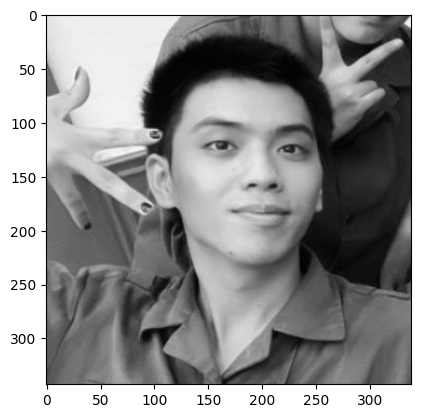

In [46]:
# Plot image using matplotlib
plt.imshow(gray, cmap='gray')

**Sử dụng haarcascade để nhận diện khuôn mặt**

In [47]:
face_cascade = cv2.CascadeClassifier("./Model/opencv/haarcascades/haarcascade_frontalface_default.xml")

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[111,  57, 168, 168]], dtype=int32)

In [48]:
# Check Face Position
(x, y, w, h) = faces[0]
x, y, w, h

(111, 57, 168, 168)

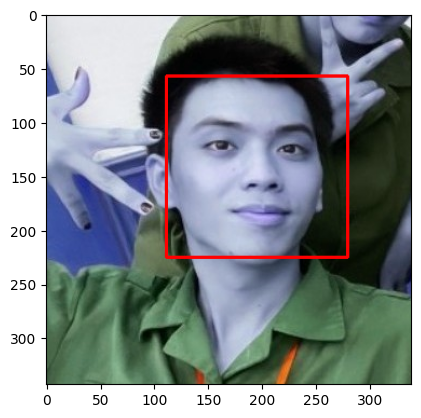

In [49]:
# Draw that face (Detect Face)
face_img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(face_img)

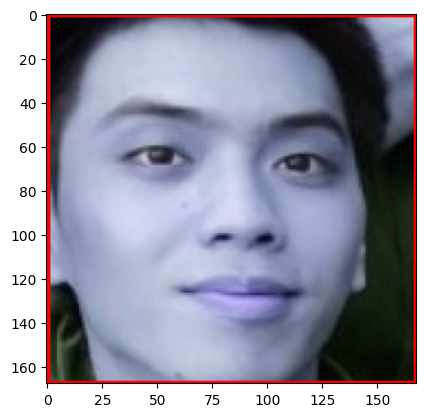

In [50]:
# Cropped Face
for (x, y, w, h) in faces:
  roi_color = img[y:y+h, x:x+w]

plt.imshow(roi_color, cmap='gray')

**Tạo ra 1 hàm dùng để chạy qua tất cả các ảnh và lấy được ảnh với khuôn mặt**

In [82]:
def get_faces(image_path):
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x, y, w, h) in faces:
    roi_color = img[y:y+h, x:x+w]
    if len(roi_color) >= 1:
      return roi_color

**Lưu tất cả ảnh đã được nhận diện bằng haarcascade vào 1 folder**

In [83]:
# Initialize some variable
path_to_data = "./Model/dataset/"
path_to_cr_data = "./Model/dataset/haar_face/"

In [84]:
# Store all subfolders in a python list
import os

img_dirs = []

for entry in os.scandir(path_to_data):
  if entry.is_dir():
    img_dirs.append(entry.path)

In [85]:
# Check img_dirs
img_dirs

['./Model/dataset/LeTanHiep_20002124',
 './Model/dataset/DinhKhaVy_20002183',
 './Model/dataset/LuyenThiQuyen_20002158',
 './Model/dataset/NguyenThiThanh_20002164',
 './Model/dataset/KhuatDangSon_20002159']

In [86]:
# Create face folder if not exists 
import shutil

if os.path.exists(path_to_cr_data):
  shutil.rmtree(path_to_cr_data)

os.mkdir(path_to_cr_data)

In [87]:
# Iterate through each of these image directory

cropped_image_dirs = []
student_file_names_dict = {}

for img_dir in img_dirs:
  count = 1
  student_name = img_dir.split('/')[-1]
  print(student_name)

  student_file_names_dict[student_name] = []

  for entry in os.scandir(img_dir):
    roi_color = get_faces(entry.path)
    if roi_color is not None:
      cropped_folder = path_to_cr_data + student_name
      if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)
        cropped_image_dirs.append(cropped_folder)
        print("Generating cropped images in folder : ", cropped_folder)

      cropped_file_name = student_name + "_" + str(count) + ".png"
      cropped_file_path = cropped_folder + "/" + cropped_file_name

      cv2.imwrite(cropped_file_path, roi_color)
      student_file_names_dict[student_name].append(cropped_file_path)
      
      count += 1

LeTanHiep_20002124
Generating cropped images in folder :  ./Model/dataset/haar_face/LeTanHiep_20002124
DinhKhaVy_20002183
Generating cropped images in folder :  ./Model/dataset/haar_face/DinhKhaVy_20002183
LuyenThiQuyen_20002158
Generating cropped images in folder :  ./Model/dataset/haar_face/LuyenThiQuyen_20002158
NguyenThiThanh_20002164
Generating cropped images in folder :  ./Model/dataset/haar_face/NguyenThiThanh_20002164
KhuatDangSon_20002159
Generating cropped images in folder :  ./Model/dataset/haar_face/KhuatDangSon_20002159


# 2. Feature Engineering (Trích xuất đặc trưng)

**Nhập thư viện**

In [89]:
import numpy as np
import pywt
import cv2

**Wavelet Transform**

In [92]:
def w2d(img, mode='haar', level=1):
  imArray = img
  '''
    Datatype conversions
  '''
  # Convert to gray scale
  imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
  # Convert to float
  imArray = np.float32(imArray)
  imArray = imArray / 255

  # Compute Coefficients
  coeffs = pywt.wavedec2(imArray, mode, level=level)

  # Process Coefficients
  coeffs_H = list(coeffs)
  coeffs_H[0] *= 0;

  # Reconstruction
  imArray_H = pywt.waverec2(coeffs_H, mode);
  imArray_H *= 255;
  imArray_H = np.uint8(imArray_H)

  return imArray_H

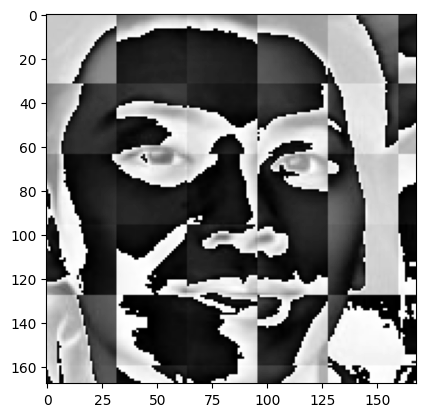

In [94]:
# Test wavelet function
cropped_image = get_faces("./Model/test_image/IMG_20221228_224730~2.jpg")
im_har = w2d(cropped_image, 'db1', 5)
plt.imshow(im_har, cmap='gray')

**Biến đổi tất cả ảnh sử dụng wavelet transform thay vì 1 ảnh như trên**

In [95]:
student_file_names_dict

{'LeTanHiep_20002124': ['./Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_1.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_2.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_3.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_4.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_5.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_6.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_7.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_8.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_9.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_10.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_11.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_12.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_13.png']

In [96]:
# Manually examine cropped folder and delete any unwanted image
student_file_names_dict = {}

for img_dir in cropped_image_dirs:
  student_name = img_dir.split('/')[-1]
  file_list = []
  for entry in os.scandir(img_dir):
    file_list.append(entry.path)
  student_file_names_dict[student_name] = file_list

student_file_names_dict

{'LeTanHiep_20002124': ['./Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_1.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_2.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_3.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_4.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_5.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_6.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_8.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_9.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_10.png',
  './Model/dataset/haar_face/LeTanHiep_20002124/LeTanHiep_20002124_11.png'],
 'DinhKhaVy_20002183': ['./Model/dataset/haar_face/DinhKhaVy_20002183/DinhKhaVy_20002183_1.png',
  './Model/dataset/haar_face/DinhKhaVy_20002183/DinhKhaVy_20002183_2.png',
  './Model/dataset/haar_face/DinhKhaVy_20002183/DinhK

**Gán cho mỗi sinh viên 1 con số**

In [97]:
class_dict = {}
count = 0
for student_name in student_file_names_dict.keys():
  class_dict[student_name] = count
  count += 1
class_dict

{'LeTanHiep_20002124': 0,
 'DinhKhaVy_20002183': 1,
 'LuyenThiQuyen_20002158': 2,
 'NguyenThiThanh_20002164': 3,
 'KhuatDangSon_20002159': 4}

**Tạo biến X và y để chứa features và labels**

In [98]:
X = []
y = []

for student_name, training_files in student_file_names_dict.items():
  for training_image in training_files:
    # Imread all image
    img = cv2.imread(training_image)
    # Check image is not None
    if img is None:
      continue
    # Resize Raw image
    scaled_raw_img = cv2.resize(img, (32, 32))
    # Get wavelet transform image
    img_har = w2d(img, 'db1', 5)
    # Resize wavelet transform image
    scaled_img_har = cv2.resize(img_har, (32, 32))
    # Vertically stack raw and wavelet image
    combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1), scaled_img_har.reshape(32*32,1)))
    # Append X
    X.append(combined_img)
    # Append y
    y.append(class_dict[student_name])

In [99]:
# Check len of X and y
len(X[0])

4096

In [100]:
# 4096 = 32*32*3 + 32*32 (Raw image + wavelet transform image)
32*32*3 + 32*32

4096

In [101]:
# Check data in X
X[0]

array([[130],
       [192],
       [203],
       ...,
       [ 14],
       [254],
       [194]], dtype=uint8)

In [103]:
# Reshape and translate into float type
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(80, 4096)

In [104]:
X[0]

array([130., 192., 203., ...,  14., 254., 194.])

# 3. Training a Model (Huấn luyện 1 mô hình)

**Ở đây chúng ta sẽ sử dụng SVM với nhân 'rbf' được tinh chỉnh bởi heuristic finetuning**

In [105]:
# Import sklearn for classification
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

**Chia tập dữ liệu thành tập Train và tập Test**

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# create pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.95

In [107]:
# Check size of Test len
len(X_test)

20

**Kiểm tra điểm số của mô hình bằng cách sử dụng classification_report**

In [108]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5

    accuracy                           0.95        20
   macro avg       0.97      0.93      0.94        20
weighted avg       0.96      0.95      0.95        20



**Sử dụng GridSearch để thử các mô hình học máy khác cũng như với các tham số khác nhau. Mục đích là để tìm ra mô hình với tham số đã được tinh chỉnh tốt nhất**

In [109]:
# Import 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [111]:
# Create model params
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf', 'linear', 'poly']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'kneighborsclassifier__n_neighbors': [1,5,10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [112]:
# Score all model
scores = []
best_estimators = {}

import pandas as pd

for algo, mp in model_params.items():
  pipe = make_pipeline(StandardScaler(), mp['model'])
  clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
  clf.fit(X_train, y_train)
  scores.append({
      'model': algo,
      'best_score': clf.best_score_,
      'best_params': clf.best_params_
  })  
  
  best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.900000,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.800000,{'randomforestclassifier__n_estimators': 5}
2,knn,0.883333,{'kneighborsclassifier__n_neighbors': 1}
3,logistic_regression,0.850000,{'logisticregression__C': 1}


In [113]:
# Check best_estimators
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'knn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

**Kiểm tra điểm số của từng model đối với tập test**

In [114]:
best_estimators['svm'].score(X_test, y_test)

0.95

In [115]:
best_estimators['random_forest'].score(X_test, y_test)

0.8

In [116]:
best_estimators['knn'].score(X_test, y_test)

0.95

In [117]:
best_estimators['logistic_regression'].score(X_test, y_test)

1.0

**-> Như vậy có thể thấy cả 3 model : svm, knn và logistic_regression đều xử lý rất tốt so với cả tập train và tập test => Chúng ta có thể chọn bất kỳ model nào trong 3 tập trên. Ở đây tôi chọn "svm"**

In [118]:
best_clf = best_estimators['svm']

In [119]:
# Check confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[2, 0, 1, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 5, 0, 0],
       [0, 0, 0, 4, 0],
       [0, 0, 0, 0, 5]])

**Sử dụng Seaborn để vẽ confusion matrix đẹp hơn**

Text(95.72222222222221, 0.5, 'Predicted')

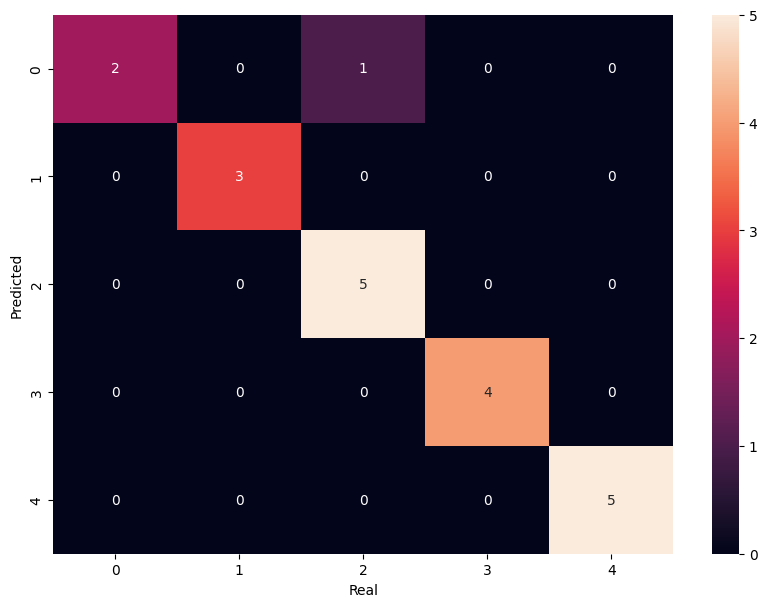

In [120]:
import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel("Real")
plt.ylabel("Predicted")

In [121]:
# Check class_dict 
class_dict

{'LeTanHiep_20002124': 0,
 'DinhKhaVy_20002183': 1,
 'LuyenThiQuyen_20002158': 2,
 'NguyenThiThanh_20002164': 3,
 'KhuatDangSon_20002159': 4}

**Lưu mô hình sau khi được huấn luyện**

In [122]:
import joblib

joblib.dump(best_clf, './Model/model1.pkl')

['./Model/model1.pkl']

**Lưu class_dictionary để phục vụ web server**

In [123]:
import json

with open("./Model/class_dictionary.json", "w") as f:
  f.write(json.dumps(class_dict))